# Geographic Gaps in CS Subfields

https://docs.google.com/document/d/1rjYFFJPjAgsiXR5c7fSpO4aEztlHhYbhAlcKaAC7hzI/edit

Question(s) to answer in this notebook:
## 1. How do countries cite each other?
## 2. How does geographic location drive the collaboration between researchers? How has this changed over time?

None of the questions in the paper address the size of a country's population, or the number of institutions/universities a country has. More the population or universities, more papers, more citations. We can control for this aspect.

Data:
- [Download](https://zenodo.org/record/6511057#.Y40_-dLMJkj)
- [Schema](https://learn.microsoft.com/en-us/academic-services/graph/reference-data-schema)

# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import reverse_geocode
import pycountry

from IPython.display import display, clear_output

dataset_dir = "mag_dataset"

# https://seaborn.pydata.org/tutorial/color_palettes.html
    
cm = sns.light_palette("green", as_cmap=True)

# Get Conferences

In [2]:
col_names = ["ConferenceSeriesId", "Rank", "NormalizedName", "DisplayName", "PaperCount", "CitationCount"]
usecols = [0, 1, 2, 3, 4, 6]

ai_conf_series = pd.read_csv("ai_conf_series.csv")
sys_conf_series = pd.read_csv("SystemsConferenceSeries.txt", delimiter="\t", usecols = usecols, names = col_names)
interdis_conf_series = pd.read_csv("InterDisConferenceSeries.txt", delimiter="\t", usecols = usecols, names = col_names)
theory_conf_series = pd.read_csv("TheoryConferenceSeries.txt", delimiter="\t", usecols = usecols, names = col_names)

conf_series = [ai_conf_series, sys_conf_series, interdis_conf_series, theory_conf_series]
area_names = ["AI", "SYSTEM", "INTERDIS", "THEORY"]

In [3]:
for conf in conf_series:
    print(len(conf))

14
39
16
7


In [4]:
def get_papers(conf_df):
    
    paper_cols = ['PaperId', 'Rank', 'Doi', 'DocType', 'PaperTitle', 'OriginalTitle', 'BookTitle', 'Year', 'Date', 'OnlineDate', 'Publisher', 'JournalId', 'ConferenceSeriesId', 'ConferenceInstanceId', 'Volume', 'Issue', 'FirstPage', 'LastPage', 'ReferenceCount', 'CitationCount', 'EstimatedCitation', 'OriginalVenue', 'FamilyId', 'FamilyRank', 'DocSubTypes', 'CreatedDate']
    use_paper_cols = ['PaperId', 'DocType', 'PaperTitle', 'Year', 'Date', 'JournalId', 'ConferenceSeriesId', 'ReferenceCount', 'CitationCount', 'FamilyId']

    total_papers = 0
    primary_papers = 0

    papers = pd.DataFrame([], columns = use_paper_cols)

    chunksize = 10 ** 4

    with pd.read_csv(dataset_dir+"/Papers.txt", chunksize=chunksize, delimiter='\t', names=paper_cols, on_bad_lines='warn', usecols = use_paper_cols) as reader:
        for chunk in reader:

            ## select required papers
            df = chunk[chunk['ConferenceSeriesId'].isin(conf_df["ConferenceSeriesId"])]
            total_papers += len(df)

            ## select "primary" papers only
            df["FamilyId"] = df["FamilyId"].astype('Int64')
            df = df[df["FamilyId"].isnull() | (df["FamilyId"]==df["PaperId"])]
            primary_papers += len(df)

            papers= pd.concat([papers, df])

            clear_output()
            
    print(f"Done retrieving paper. {total_papers} total papers. {primary_papers} primary papers.")
    
    return papers

# Get paper location 

In [5]:
def get_paper_location(papers_df):
    
    ## Get Authors and Affilications
    
    paper_auth_aff_cols = ["PaperId", "AuthorId", "AffiliationId", "AuthorSequenceNumber"]

    total_papers_with_auths = 0

    paper_auth_aff = pd.DataFrame([], columns = paper_auth_aff_cols)

    chunksize = 10 ** 4

    with pd.read_csv(dataset_dir+"/PaperAuthorAffiliations.txt", chunksize=chunksize,  delimiter='\t', names=paper_auth_aff_cols, on_bad_lines='warn', usecols=[0, 1, 2, 3]) as reader:
        for chunk in reader:

            ## select required papers
            df = chunk[(chunk['PaperId'].isin(papers_df["PaperId"]))]
            total_papers_with_auths += len(df)

            paper_auth_aff= pd.concat([paper_auth_aff, df])

            clear_output()

    print(f"Done retrieving authors and affiliations. {total_papers_with_auths} total authors and affiliations.")
    
    ## Get Locations
    
    aff_cols = ['AffiliationId', 'DisplayName', 'Iso3166Code', 'Latitude', 'Longitude']

    all_aff = pd.read_csv(dataset_dir+"/Affiliations.txt", delimiter='\t', names=aff_cols, usecols = [0, 3, 10, 11, 12])
    
    paper_auth_aff_with_geo = paper_auth_aff.merge(all_aff.set_index('AffiliationId'), on = 'AffiliationId', how='inner')\
                                            .rename(columns = {col:"Aff_"+col for col in all_aff.columns[1:]})\
                                            .dropna()
    
    ## Get country name from ISO code

    paper_auth_aff_with_geo["Aff_country"] = paper_auth_aff_with_geo["Aff_Iso3166Code"]\
                        .apply(lambda iso: pycountry.countries.get(alpha_2=iso).name)\
                        .apply(lambda x: x.split(",")[0]) ## "Korea, Republic of" --> "Korea"
    
    print(f"Done retrieving paper locations. {len(paper_auth_aff_with_geo)} total rows.")

    return paper_auth_aff_with_geo

# Paper references (citations)

In [6]:
def get_paper_references(papers_df):
    
    paper_references_cols = ["PaperId", "PaperReferenceId"]

    total_paper_refs = 0

    paper_refs = pd.DataFrame([], columns = paper_references_cols)

    chunksize = 10 ** 6

    with pd.read_csv(dataset_dir+"/PaperReferences.txt", chunksize=chunksize, delimiter='\t', names=paper_references_cols,on_bad_lines='warn') as reader:
        for chunk in reader:

            ## select required papers
            df = chunk[(chunk['PaperId'].isin(papers_df["PaperId"])) &\
                       (chunk['PaperReferenceId'].isin(papers_df["PaperId"]))]
            total_paper_refs += len(df)

            paper_refs= pd.concat([paper_refs, df])

            clear_output()

    print(f"Done retrieving paper references. {total_paper_refs} total rows.")
    
    return paper_refs

# Q1: How to countries cite each other?

In [7]:
def combine_ref_location(paper_refs, paper_auth_aff_with_geo):
    # returns paper_refs_country
    return paper_refs.merge(paper_auth_aff_with_geo[["PaperId", "Aff_country"]], on="PaperId", how="inner")\
              .rename(columns = {"PaperId":"Paper", "PaperReferenceId": "Ref_Paper", "Aff_country":"Paper_country"})\
              .merge(paper_auth_aff_with_geo[["PaperId", "Aff_country"]], left_on="Ref_Paper", right_on="PaperId", how="inner")\
              .rename(columns = {"Aff_country":"Ref_Paper_country"})\
              .drop(columns = ["PaperId"])\
              .drop_duplicates()

### Create matrix and plot

In [8]:
def create_matrix(paper_refs_country):
    
    country_grouped = paper_refs_country.groupby(["Paper_country", "Ref_Paper_country"])\
                      .count()\
                      .iloc[:,0].to_frame().rename(columns = {"Paper":"count"})\
                      .reset_index().sort_values("count", ascending=False)
    
    ## all countries
    countries_ref = pd.concat([country_grouped["Paper_country"], country_grouped["Ref_Paper_country"]])
    num_countries = countries_ref.nunique()
    
    # Create index for countries
    country_index = countries_ref.unique()
    country_rev_index = {country:i for i, country in enumerate(countries_ref.unique())}
    
    ## create matrix
    matrix = np.zeros((num_countries, num_countries))
    for (country1, country2), df in paper_refs_country.groupby(["Paper_country", "Ref_Paper_country"]):
        matrix[country_rev_index[country1], country_rev_index[country2]] = len(df)
        
    return matrix, country_index, country_rev_index

In [9]:
def plot_citation_heat_map(matrix, country_index, num_countries_to_show = 20, scale = 100, file_name=None):

    fig,ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(20)

    matrix_to_show = matrix[:num_countries_to_show, :num_countries_to_show]
    country_names = country_index[:num_countries_to_show]
    matrix_to_show = matrix_to_show/scale

    sns.heatmap(matrix_to_show, annot=True, cmap="crest", fmt='3.1f', linewidths=.05,
                xticklabels=country_names, yticklabels=country_names, vmin=1000/scale) # vmax=
    
    if file_name:
        plt.savefig(file_name)
        
    plt.show()
    
    return matrix_to_show, country_names

In [16]:
## Who (countries) are most cited in each country
## Column-Wise heatmaps

def columnwise_conditionalformat(matrix_to_show, country_names, color = 'Oranges', num_countries_to_show = 20, file_name=None):
    
    df = pd.DataFrame(matrix_to_show, columns=country_names, index=country_names).astype(int).iloc[::-1,:]
    
    nrows = len(df)
    ncols = len(df.columns)
    fig, ax = plt.subplots(figsize=(15,10))
    for i in range(ncols):
        truthar = [True]*ncols
        truthar[i] = False
        mask = truthar = np.array(nrows * [truthar], dtype=bool)
        red = np.ma.masked_where(mask, df)
        ax.pcolormesh(red, cmap=color)

    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            plt.text(x+.5,y+.5,'%3.1f'% df.iloc[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',)
#                      color="white" if(y==19 or (y==18 and x==1)) else "black" 
    
    plt.xticks(range(num_countries_to_show), country_names, rotation=90)
    plt.yticks(range(num_countries_to_show), country_names[::-1])
    
    if file_name:
        plt.savefig(file_name)
    
    plt.show()

Done retrieving paper references. 66930 total rows.


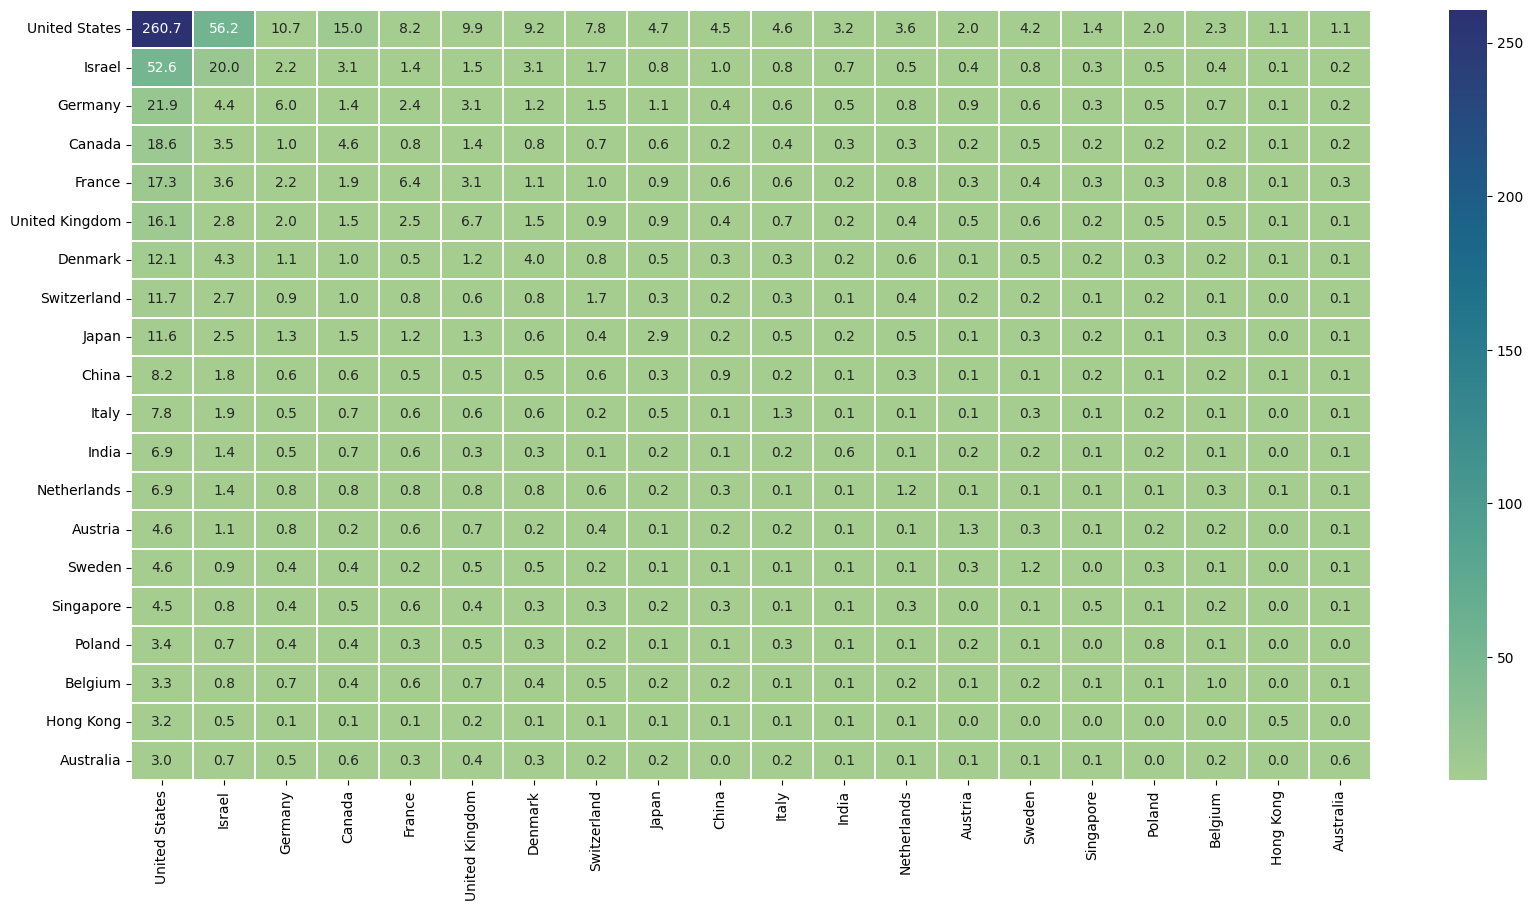

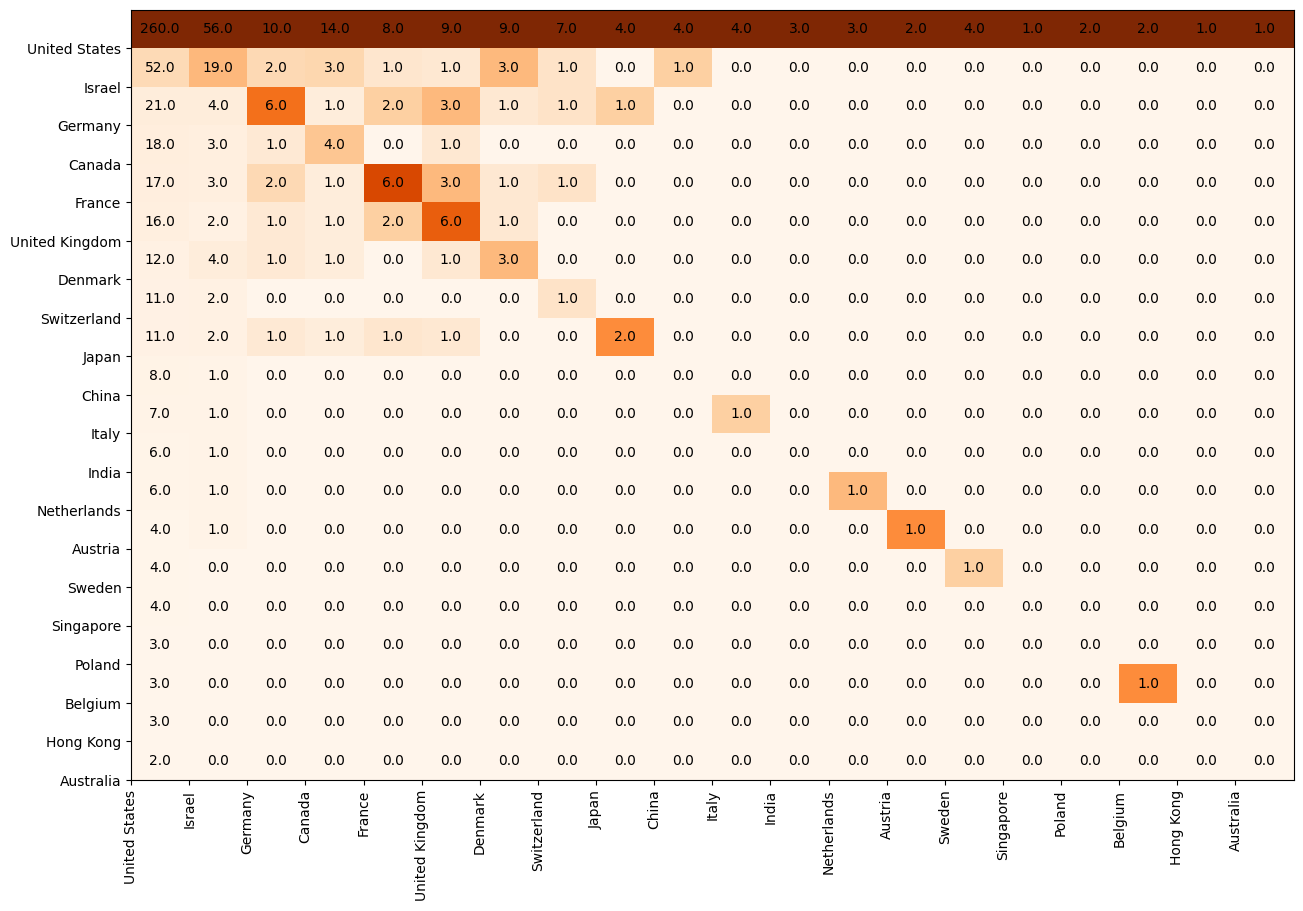

In [17]:
for conf_df, area_name in zip(conf_series[1:], area_names[1:]):
    
    print(f"Starting {area_name}...")
    
    papers = get_papers(conf_df)
    papers.to_csv(area_name+"/papers.csv", index=False)
    
    paper_auth_aff_with_geo = get_paper_location(papers)
    paper_auth_aff_with_geo.to_csv(area_name+"/paper_auth_aff_with_geo.csv", index=False)
    
    paper_refs = get_paper_references(papers)
    paper_refs.to_csv(area_name+"/paper_refs.csv", index=False)
    
    paper_refs_country = combine_ref_location(paper_refs, paper_auth_aff_with_geo)
    paper_refs_country.to_csv(area_name+"/paper_refs_country.csv", index=False)
    
    matrix, country_index, country_rev_index = create_matrix(paper_refs_country)
    
    matrix_to_show, country_names = plot_citation_heat_map(matrix, country_index, file_name=area_name+"/heatmap.png")
    columnwise_conditionalformat(matrix_to_show, country_names, file_name=area_name+"/columnheatmap.png")